# A/H 溢价季度策略回测分析

本 Notebook 参考 `ah_premium_quarterly_bt.py`，分步实现 A/H 溢价季度策略回测，便于交互分析和结果展示。

In [1]:
# 导入必要库
import duckdb
from qs.backtester.data import Bar, DataFeed
from qs.backtester.broker import Broker
from qs.backtester.engine import BacktestEngine
from qs.backtester.stats import (
    compute_annual_returns,
    compute_max_drawdown,
    compute_risk_metrics,
)
from qs.strategy.ah_premium_quarterly import AHPremiumQuarterlyStrategy
import matplotlib.pyplot as plt

In [2]:
# 全局字体设置（中文显示 & 负号正常 & 回退逻辑）
import matplotlib
from matplotlib import font_manager, rcParams
import os, warnings

# 可选：抑制 glyph 缺失警告（若仍未找到字体时可打开）
# warnings.filterwarnings('ignore', 'Glyph .* missing from font')

# 1. 首先尝试直接已注册字体
preferred_names = [
    "Microsoft YaHei",
    "SimHei",
    "Arial Unicode MS",
    "Noto Sans CJK SC",
    "Source Han Sans CN",
    "Source Han Sans SC",
]

available = {f.name for f in font_manager.fontManager.ttflist}
selected = None
for name in preferred_names:
    if name in available:
        selected = name
        break

# 2. 若未命中，尝试手动添加常见 Windows 字体路径
if selected is None:
    candidate_files = [
        r"C:\\Windows\\Fonts\\msyh.ttc",  # 微软雅黑
        r"C:\\Windows\\Fonts\\msyhl.ttc",  # 微软雅黑Light
        r"C:\\Windows\\Fonts\\simhei.ttf",  # 黑体
        r"C:\\Windows\\Fonts\\msyh.ttf",  # 旧格式
    ]
    for fp in candidate_files:
        if os.path.exists(fp):
            try:
                font_manager.fontManager.addfont(fp)
            except Exception:
                pass
    # 重新获取
    available = {f.name for f in font_manager.fontManager.ttflist}
    for name in preferred_names:
        if name in available:
            selected = name
            break

# 3. 再次 fallback：若依旧没有，尝试下载/放置 Noto Sans （此处提示，不自动下载）
if selected is None:
    print(
        "[字体提示] 未找到常见中文字体，可下载 Noto Sans CJK 放入 fonts/ 目录, 如: fonts/NotoSansCJKsc-Regular.otf"
    )
    local_noto = "fonts/NotoSansCJKsc-Regular.otf"
    if os.path.exists(local_noto):
        try:
            font_manager.fontManager.addfont(local_noto)
            available = {f.name for f in font_manager.fontManager.ttflist}
            for name in preferred_names:
                if name in available:
                    selected = name
                    break
        except Exception as e:
            print("[字体加载失败]", e)

# 4. 设置 rcParams
if selected:
    rcParams["font.sans-serif"] = [selected]
else:
    # 最后保留 DejaVu Sans 但提示
    print("[警告] 仍使用默认字体，中文可能乱码。")
rcParams["axes.unicode_minus"] = False
print("Using font family:", rcParams.get("font.sans-serif", []))

Using font family: ['Microsoft YaHei']


In [3]:
# 加载交易日历数据
start_date = "20180101"
db_path = "data/data.duckdb"
con = duckdb.connect(db_path, read_only=True)
q = f"""
SELECT trade_date,
       MIN(open) AS open,
       MIN(high) AS high,
       MIN(low) AS low,
       MIN(close) AS close,
       NULL AS pct_chg
FROM (
  SELECT trade_date, open, high, low, close FROM daily_a
  UNION ALL
  SELECT trade_date, open, high, low, close FROM daily_h
)
WHERE trade_date >= '{start_date}'
GROUP BY 1
ORDER BY 1
"""
rows = con.execute(q).fetchall()
con.close()
bars = [Bar(*r) for r in rows]
feed = DataFeed(bars)
print(f"Loaded {len(bars)} trading days from {start_date}")

Loaded 1926 trading days from 20180101


In [4]:
# 设置回测参数
TOP_K = 5
BOTTOM_K = 5
START_DATE = "20180101"
INIT_CASH = 1_000_000
CAPITAL_SPLIT = 0.5  # H股分配比例

In [5]:
# 初始化回测组件
broker = Broker(cash=INIT_CASH, enable_trade_log=False)
strat = AHPremiumQuarterlyStrategy(
    top_k=TOP_K,
    bottom_k=BOTTOM_K,
    start_date=START_DATE,
    capital_split=CAPITAL_SPLIT,
    premium_use_adjusted=False,  # 溢价采用原始价，避免前复权跨标的失真
    use_adjusted=True,  # 头寸估值/成交仍用复权价
)
engine = BacktestEngine(feed, broker, strat)

[AHPremiumQuarterlyStrategy] __init__ preload factors: 0.144s (premium_use_adjusted=False)


In [6]:
# 运行回测引擎
curve = engine.run()
print(f"回测完成，曲线长度: {len(curve)}")

[AHPremiumQuarterlyStrategy] _load_premium_for_date(20180330): 0.095s, 0 records (premium_use_adjusted=False)
[AHPremiumQuarterlyStrategy] _load_premium_for_date(20180629): 0.096s, 94 records (premium_use_adjusted=False)
[AHPremiumQuarterlyStrategy] _load_opens(20180702): 0.053s, 5 symbols (use_adjusted=True)
[AHPremiumQuarterlyStrategy] rebalance 20180702 premium_date=20180629 A_count=5 H_count=5
  symbol=600585.SH leg=A prem=-12.04% wt=0.1000 A_raw=33.4800 H_raw=38.0637 A_adj=24.2828 H_adj=26.0051 pair=海螺水泥
  symbol=000898.SZ leg=A prem=-6.99% wt=0.1000 A_raw=5.5700 H_raw=5.9887 A_adj=3.6694 H_adj=3.8250 pair=鞍钢股份
  symbol=000338.SZ leg=A prem=-4.39% wt=0.1000 A_raw=8.7500 H_raw=9.1522 A_adj=6.8162 H_adj=6.8285 pair=潍柴动力
  symbol=601318.SH leg=A prem=-4.08% wt=0.1000 A_raw=58.5800 H_raw=61.0712 A_adj=44.2472 H_adj=44.4842 pair=中国平安
  symbol=601211.SH leg=A prem=4.47% wt=0.1000 A_raw=14.7400 H_raw=14.1090 A_adj=12.0148 H_adj=9.7183 pair=国泰海通
  symbol=00187.HK leg=H prem=209.30% wt=0.1

In [7]:
# 计算年度收益率
ann = compute_annual_returns(curve)
print("年度收益率:")
for y, r in ann.items():
    print(f"  {y}: {r:.2%}")

年度收益率:
  2018: -4.72%
  2019: 39.90%
  2020: 52.46%
  2021: 20.32%
  2022: -0.87%
  2023: -5.56%
  2024: 35.86%
  2025: 52.07%


In [8]:
# 计算最大回撤
max_dd, dd_peak, dd_trough = compute_max_drawdown(curve)
print(f"最大回撤: {max_dd:.2%} from {dd_peak} to {dd_trough}")

最大回撤: -30.21% from 20241007 to 20250113


In [9]:
# 计算风险指标
risk = compute_risk_metrics(curve, INIT_CASH)
print("风险指标:")
for k, v in risk.items():
    if k.endswith("Rate") or k in ("CAGR", "AnnReturn", "AnnVol", "Sharpe"):
        print(f"  {k}: {v:.4f}")
    else:
        print(f"  {k}: {v}")

风险指标:
  CAGR: 0.2254
  AnnReturn: 0.2732
  AnnVol: 0.2779
  Sharpe: 0.9828
  WinRate: 0.4803


## 策略 vs 三大指数归一化收益曲线对比

下方代码将查询 `index_daily` (000300.SH) 与 `index_global` (HSI, IXIC) 的收盘价，与策略净值一起按起始日期归一化后绘制对比曲线。

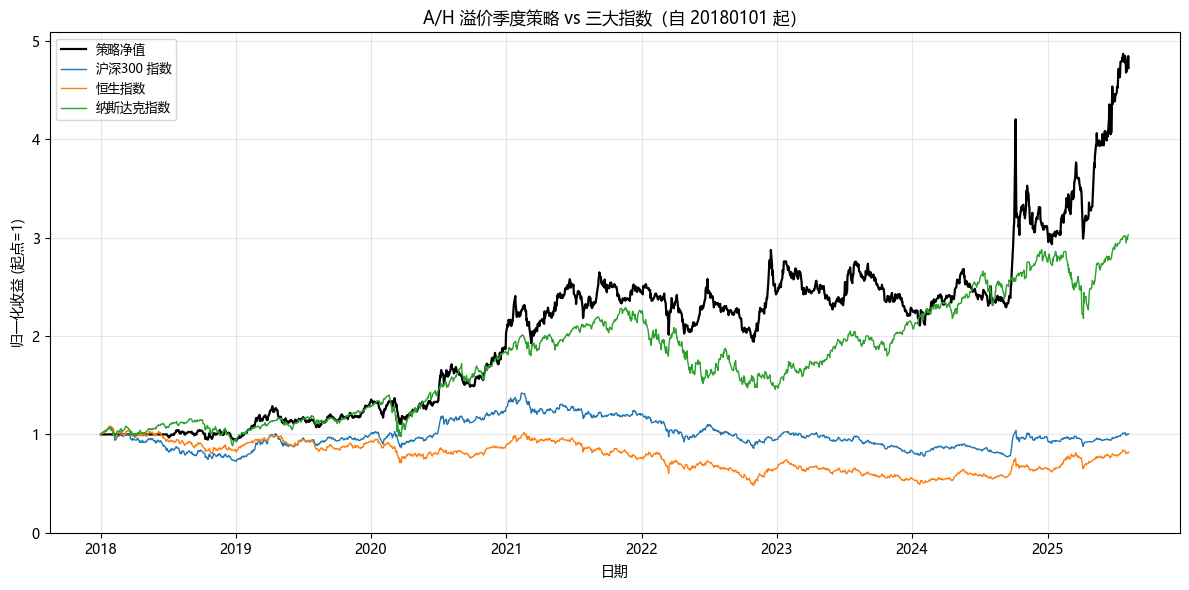

In [10]:
# 三大指数与策略净值归一化对比绘图
import pandas as pd

# 1. 读取指数数据
con = duckdb.connect("data/data.duckdb", read_only=True)
idx_sh300 = con.execute(
    "SELECT trade_date, close FROM index_daily WHERE ts_code='000300.SH' AND trade_date >= ? ORDER BY trade_date",
    [START_DATE],
).fetchdf()
idx_hsi = con.execute(
    "SELECT trade_date, close FROM index_global WHERE ts_code='HSI' AND trade_date >= ? ORDER BY trade_date",
    [START_DATE],
).fetchdf()
idx_ixic = con.execute(
    "SELECT trade_date, close FROM index_global WHERE ts_code='IXIC' AND trade_date >= ? ORDER BY trade_date",
    [START_DATE],
).fetchdf()
con.close()

# 2. 转换日期 & 归一化
for df in (idx_sh300, idx_hsi, idx_ixic):
    df["date"] = pd.to_datetime(df["trade_date"])
    base = df["close"].iloc[0] if not df.empty else 1.0
    df["norm"] = df["close"] / base

# 策略曲线 DataFrame
curve_df = pd.DataFrame(
    {
        "date": [pd.to_datetime(b.trade_date) for b in curve],
        "equity": [b.equity for b in curve],
    }
)
curve_df.sort_values("date", inplace=True)
curve_df["norm"] = curve_df["equity"] / curve_df["equity"].iloc[0]

# 3. 对齐日期（内连接可选；此处保持各自跨度，绘图自动处理）

# 4. 绘图
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(
    curve_df["date"], curve_df["norm"], label="策略净值", linewidth=1.6, color="black"
)
ax.plot(idx_sh300["date"], idx_sh300["norm"], label="沪深300 指数", linewidth=1.0)
ax.plot(idx_hsi["date"], idx_hsi["norm"], label="恒生指数", linewidth=1.0)
ax.plot(idx_ixic["date"], idx_ixic["norm"], label="纳斯达克指数", linewidth=1.0)

ax.set_title(f"A/H 溢价季度策略 vs 三大指数（自 {START_DATE} 起）")
ax.set_xlabel("日期")
ax.set_ylabel("归一化收益 (起点=1)")
ax.set_ylim(bottom=0)
ax.legend(loc="upper left", fontsize=9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [11]:
# 交易历史总费用汇总
from collections import defaultdict

print(f"总费用(佣金+卖出税): {broker.total_fees:.2f}")
print(f"成交笔数: {len(broker.trades)}")
if broker.trades:
    # 按年份汇总费用
    yearly = defaultdict(float)
    for tr in broker.trades:
        yearly[tr.trade_date[:4]] += tr.fees
    print("年度费用:")
    for y in sorted(yearly):
        print(f"  {y}: {yearly[y]:.2f}")
    # 前几条示例
    print("前5条交易记录(日期, 动作, 标的, 手数, 费用):")
    for tr in broker.trades[:5]:
        print(
            f"  {tr.trade_date} {tr.action} {tr.symbol} size={int(tr.size)} fees={tr.fees:.2f}"
        )

总费用(佣金+卖出税): 10533.98
成交笔数: 217
年度费用:
  2018: 149.98
  2019: 1185.48
  2020: 1246.20
  2021: 2380.22
  2022: 2128.22
  2023: 873.46
  2024: 340.50
  2025: 2229.94
前5条交易记录(日期, 动作, 标的, 手数, 费用):
  20180702 BUY 000898.SZ size=27295 fees=15.00
  20180702 BUY 000338.SZ size=14651 fees=15.00
  20180702 BUY 600585.SH size=4114 fees=15.00
  20180702 BUY 601211.SH size=8321 fees=15.00
  20180702 BUY 601318.SH size=2271 fees=15.00


In [ ]:
# 历史全部交易明细（含名称 & 上一交易日 AH 溢价，直接来自 strategy.rebalance_history）
import pandas as pd
import duckdb

if broker.trades:
    # 1. 基础交易表
    trades_df = pd.DataFrame(
        [
            {
                "date": t.trade_date,
                "action": t.action,
                "symbol": t.symbol,
                "price_signal": t.price,
                "price_exec": t.exec_price,
                "size": t.size,
                "gross_amount": t.gross_amount,
                "fees": t.fees,
                "cash_after": t.cash_after,
                "position_after": t.position_after,
                "equity_after": t.equity_after,
            }
            for t in broker.trades
        ]
    )
    trades_df["date"] = pd.to_datetime(trades_df["date"])

    # 2. 名称映射
    symbols = sorted(trades_df["symbol"].unique())
    if symbols:
        sym_list_sql = ",".join([f"'{s}'" for s in symbols])
        con_tmp = duckdb.connect("data/data.duckdb", read_only=True)
        name_rows = con_tmp.execute(
            f"""
            SELECT ts_code, name FROM stock_basic_a WHERE ts_code IN ({sym_list_sql})
            UNION ALL
            SELECT ts_code, name FROM stock_basic_h WHERE ts_code IN ({sym_list_sql})
            """
        ).fetchall()
        con_tmp.close()
        name_map = {r[0]: r[1] for r in name_rows}
        trades_df["name"] = trades_df["symbol"].map(name_map)
    else:
        trades_df["name"] = ""

    # 3. 使用 strategy.rebalance_history 构建 (rebalance_date, symbol) -> premium 信息
    hist = (
        strat.get_rebalance_history() if hasattr(strat, "get_rebalance_history") else []
    )
    premium_lookup = {}
    for rec in hist:
        rdate = rec.get("rebalance_date")
        pdate = rec.get("premium_date")
        for d in rec.get("decisions", []):
            premium_lookup[(rdate, d["symbol"])] = {
                "premium_date": pdate,
                "premium_pct": d.get("premium_pct"),
                "leg": d.get("leg"),
                "pair_name": d.get("pair_name"),
                "target_weight": d.get("target_weight"),
            }

    prem_dates = []
    prem_vals = []
    legs = []
    pair_names = []
    target_w = []
    for _, row in trades_df.iterrows():
        key = (row["date"].strftime("%Y%m%d"), row["symbol"])
        info = premium_lookup.get(key)
        if info:
            prem_dates.append(info["premium_date"])
            prem_vals.append(info["premium_pct"])
            legs.append(info.get("leg"))
            pair_names.append(info.get("pair_name"))
            target_w.append(info.get("target_weight"))
        else:
            prem_dates.append(None)
            prem_vals.append(None)
            legs.append(None)
            pair_names.append(None)
            target_w.append(None)
    trades_df["premium_date"] = prem_dates
    trades_df["premium_pct"] = prem_vals
    trades_df["leg"] = legs
    trades_df["pair_name"] = pair_names
    trades_df["target_weight"] = target_w

    # 4. 排序 / 列顺序
    trades_df.sort_values(["date", "symbol"], inplace=True)
    cols_order = [
        "date",
        "premium_date",
        "premium_pct",
        "symbol",
        "name",
        "pair_name",
        "leg",
        "action",
        "size",
        "target_weight",
        "price_signal",
        "price_exec",
        "gross_amount",
        "fees",
        "cash_after",
        "position_after",
        "equity_after",
    ]
    trades_df = trades_df[cols_order]

    pd.set_option("display.max_rows", None)
    display(trades_df)
    print(
        f"共 {len(trades_df)} 笔交易。premium_pct 来源 strategy.rebalance_history (premium_date 为上一交易日)。"
    )
else:
    print("无交易记录。")

,date,premium_date,premium_pct,symbol,name,pair_name,leg,action,size,target_weight,price_signal,price_exec,gross_amount,fees,cash_after,position_after,equity_after
1,2018-07-02,20180629,-4.394735,000338.SZ,潍柴动力,潍柴动力,A,BUY,14651,0.1,6.823949,6.825314,99997.674261,14.999651,7.999756e+05,14651.0,9.999700e+05
0,2018-07-02,20180629,-6.991432,000898.SZ,鞍钢股份,鞍钢股份,A,BUY,27295,0.1,3.662821,3.663553,99996.687604,14.999503,8.999883e+05,27295.0,9.999850e+05
2,2018-07-02,20180629,-12.042282,600585.SH,海螺水泥,海螺水泥,A,BUY,4114,0.1,24.297336,24.302195,99979.230876,14.996885,6.999814e+05,4114.0,9.999550e+05
3,2018-07-02,20180629,4.472613,601211.SH,国泰海通,国泰海通,A,BUY,8321,0.1,12.014800,12.017203,99995.144079,14.999272,5.999713e+05,8321.0,9.999400e+05
4,2018-07-02,20180629,-4.079112,601318.SH,中国平安,中国平安,A,BUY,2271,0.1,44.020583,44.029387,99990.738979,14.998611,4.999655e+05,2271.0,9.999250e+05
5,2018-10-02,20180928,326.594287,00568.HK,山东墨龙,山东墨龙,H,BUY,87061,0.1,1.195396,1.195635,104093.167215,15.613975,3.958567e+05,87061.0,1.040922e+06
6,2018-10-02,20180928,350.092121,01057.HK,浙江世宝,浙江世宝,H,BUY,110479,0.1,0.942016,0.942204,104093.781446,15.614067,2.917474e+05,110479.0,1.040907e+06
7,2018-10-02,20180928,204.734228,01065.HK,天津创业环保股份,天津创业环保股份,H,BUY,55269,0.1,1.883017,1.883394,104093.299362,15.613995,1.876384e+05,55269.0,1.040891e+06
9,2018-10-02,20180928,518.250676,01108.HK,凯盛新能,凯盛新能,H,BUY,39255,0.1,2.127101,2.127527,83516.062565,12.527409,8.953362e-01,39255.0,1.040863e+06
8,2018-10-02,20180928,450.357358,01330.HK,绿色动力环保,绿色动力环保,H,BUY,55633,0.1,1.870698,1.871072,104093.340907,15.614001,8.352949e+04,55633.0,1.040875e+06


共 217 笔交易。premium_pct 来源 strategy.rebalance_history (premium_date 为上一交易日)。
